Epoch 1, Training Loss: 0.7027, Validation Error: 0.5510
Epoch 26, Training Loss: 0.6696, Validation Error: 0.4490
Epoch 51, Training Loss: 0.6702, Validation Error: 0.4490
Epoch 76, Training Loss: 0.6697, Validation Error: 0.4490
Epoch 101, Training Loss: 0.6698, Validation Error: 0.4490
Epoch 126, Training Loss: 0.6701, Validation Error: 0.4490
Training Metrics - Accuracy: 0.6102, Precision: 0.6102, Recall: 1.0000, F1 Score: 0.7579
Test Metrics - Accuracy: 0.5600, Precision: 0.5600, Recall: 1.0000, F1 Score: 0.7179
Epoch 1, Training Loss: 0.6997, Validation Error: 0.6818
Epoch 26, Training Loss: 0.6914, Validation Error: 0.6818
Epoch 51, Training Loss: 0.6913, Validation Error: 0.6818
Epoch 76, Training Loss: 0.6918, Validation Error: 0.6818
Epoch 101, Training Loss: 0.6922, Validation Error: 0.6818
Epoch 126, Training Loss: 0.6925, Validation Error: 0.3182

Avg cross-validation metrics for fold 1: Accuracy: 68.18%, Precision: 0.6818, Recall: 1.0000, F1 Score: 0.8108


Avg cross-vali

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Avg cross-validation metrics for fold 10: Accuracy: 54.55%, Precision: 0.5455, Recall: 1.0000, F1 Score: 0.7059


Avg cross-validation accuracy for fold 10: 54.54545454545454% 

Cross-Validation Accuracies: [0.6818181818181818, 0.7272727272727273, 0.6136363636363636, 0.5681818181818182, 0.6136363636363636, 0.5227272727272727, 0.5227272727272727, 0.6136363636363636, 0.5681818181818182, 0.5454545454545454]
Cross-Validation Precisions: [0.6818181818181818, 0.7272727272727273, 0.6136363636363636, 0.5681818181818182, 0.6136363636363636, 0.5227272727272727, 0.5227272727272727, 0.6136363636363636, 0.5681818181818182, 0.5454545454545454]
Cross-Validation Recalls: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Cross-Validation F1 Scores: [0.8108108108108109, 0.8421052631578947, 0.7605633802816901, 0.7246376811594203, 0.7605633802816901, 0.6865671641791045, 0.6865671641791045, 0.7605633802816901, 0.7246376811594203, 0.7058823529411765]
Average Cross-Validation Accuracy: 59.77%
Average Cross

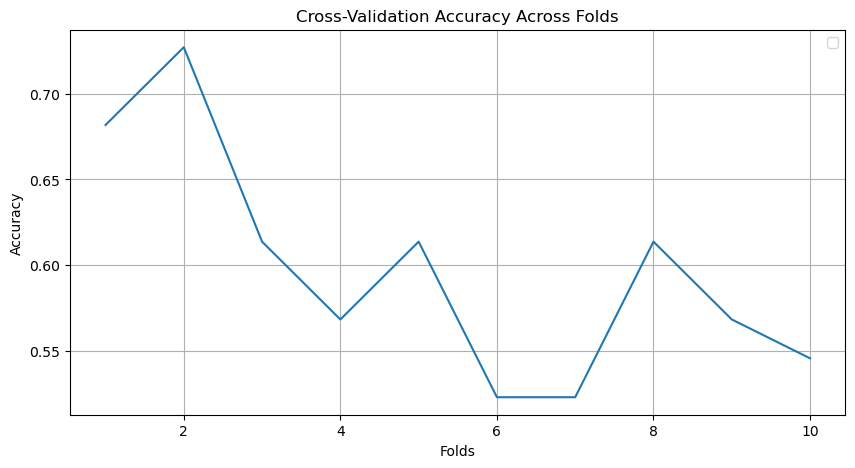

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Tkinter root window
root = tk.Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()

# Normalize data and assign movement direction values
def prep(dataset):
    scaler = StandardScaler()

    dataset['RSI (14D)'] = ta.rsi(dataset['Close'], length=14)
    dataset['20 Day CCI'] = ta.cci(high=dataset['High'], low=dataset['Low'], 
                                   close=dataset['Close'], length=20)
    dataset['Williams %R'] = ta.willr(high=dataset['High'], low=dataset['Low'], 
                                      close=dataset['Close'], length=14)
    dataset['EMA (5D)'] = dataset['Close'].ewm(span=5, adjust=False).mean()

    bollinger = ta.bbands(dataset['Close'], length=20, std=2)
    dataset['BB_upper'] = bollinger['BBU_20_2.0']
    dataset['BB_middle'] = bollinger['BBM_20_2.0']
    dataset['BB_lower'] = bollinger['BBL_20_2.0']

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R', 'Mortgage_rate', 'Unemp_rate',
                'disposable_income', 'Personal_consumption_expenditure', 
                'personal_savings']
    
    dataset[features] = dataset[features].astype(float)
    dataset[features] = scaler.fit_transform(dataset[features])

    dataset['MA10'] = dataset['Close'].rolling(window=10).mean()
    dataset['MA50'] = dataset['Close'].rolling(window=50).mean()
    
    dataset['Target'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)
    prepared_data = dataset.dropna().tail(503)
    return prepared_data, scaler

# Define LSTM Model class
class LSTM_Model(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(LSTM_Model, self).__init__()
        self.hidden_layer = hidden_layer
        #self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_layer, hidden_layer, batch_first=True, bidirectional=False)
        self.linear_layer = nn.Linear(hidden_layer, output_layer)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer).cuda(),
                            torch.zeros(1,1,self.hidden_layer).cuda())

    def forward(self, input_tensor):
        self.hidden_cell = (torch.zeros(1, input_tensor.size(0), self.hidden_layer).cuda(), 
                            torch.zeros(1, input_tensor.size(0), self.hidden_layer).cuda())
        out, self.hidden_cell = self.lstm(input_tensor, self.hidden_cell)
        lstm_out_last = out[:, -1, :]
        predicted_values = self.linear_layer(lstm_out_last)
        return predicted_values

# Create sequences for input data and corresponding labels
def create_sequence(input_data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(input_data) - sequence_length):
        sequence = input_data[i : i + sequence_length, :-1]
        label = input_data[i + sequence_length, -1]
        sequences.append(sequence)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels

# Convert sequences and labels to PyTorch tensors
def convert_to_tensor(sequences, labels):
    # Convert sequences to tensors if they are not already
    if not isinstance(sequences[0], torch.Tensor):
        sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    
    # Convert labels to tensor and reshape
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
    else:
        labels = labels.view(-1, 1)  # Ensure the correct shape if already a tensor

    # Pad sequences
    sequences = pad_sequence(sequences, batch_first=True)
    
    return sequences, labels

# Train the model with data provided
def trainer(model, train_data, val_data, loss_func, opt, epochs, device='cuda'):
    train_errors, val_errors = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for sequence, labels in train_data:
            opt.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer).to(device),
                                 torch.zeros(1, 1, model.hidden_layer).to(device))
            
            sequence = sequence.to(device)
            labels = labels.to(device)

            y = model(sequence)
            loss = loss_func(y, labels)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Compute average loss for the epoch
        train_errors.append(epoch_loss / len(train_data))

        # Validate the model
        val_metrics = evaluate_model(model, val_data, device)
        val_accuracy = val_metrics['accuracy']  # Extract accuracy
        val_errors.append(1 - val_accuracy)  # Convert accuracy to error

        # Print progress
        if epoch % 25 == 1:
            print(f'Epoch {epoch}, Training Loss: {epoch_loss / len(train_data):.4f}, Validation Error: {1 - val_accuracy:.4f}')
    
    return train_errors, val_errors

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    predictions, labels = [], []
    
    with torch.no_grad():
        for sequence, label in data_loader:
            sequence = sequence.float().to(device)
            output = model(sequence)
            pred = torch.round(torch.sigmoid(output)).cpu().numpy()
            predictions.extend(pred.flatten())
            labels.extend(label.numpy())
    
    # Convert lists to numpy arrays for sklearn metric functions
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Time Series Cross-Validation
def time_series_cv(model_class, sequences, labels, n_splits, epochs, device='cuda'):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    i = 1

    for train_index, test_index in tscv.split(sequences):
        train_sequences, test_sequences = [sequences[i] for i in train_index], [sequences[i] for i in test_index]
        train_labels, test_labels = [labels[i] for i in train_index], [labels[i] for i in test_index]
        
        # Convert to tensors
        train_sequences, train_labels = convert_to_tensor(train_sequences, train_labels)
        test_sequences, test_labels = convert_to_tensor(test_sequences, test_labels)

        # Create dataLoaders
        train_data = torch.utils.data.DataLoader(list(zip(train_sequences, train_labels)), shuffle=True, batch_size=100)
        test_data = torch.utils.data.DataLoader(list(zip(test_sequences, test_labels)), shuffle=False, batch_size=100)
        
        # Initialize model
        model = model_class(input_layer=15, hidden_layer=50, output_layer=1).to(device)
        opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.2)
        loss_func = nn.BCEWithLogitsLoss()

        # Train and evaluate
        train_errors, val_errors = trainer(model, train_data, test_data, loss_func, opt, epochs, device)
        test_metrics = evaluate_model(model, test_data, device)
        
        accuracies.append(test_metrics['accuracy'])
        precisions.append(test_metrics['precision'])
        recalls.append(test_metrics['recall'])
        f1_scores.append(test_metrics['f1_score'])

        print(f'\nAvg cross-validation metrics for fold {i}: Accuracy: {accuracies[-1] * 100:.2f}%, '
              f'Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1 Score: {f1_scores[-1]:.4f}\n')

        print(f'\nAvg cross-validation accuracy for fold {i}: {accuracies[-1] * 100}% \n')

        i += 1
    
    return accuracies, precisions, recalls, f1_scores

# Load and prepare data
file_path = filedialog.askopenfilename(parent=root, title="Select A File")
ticker = pd.read_csv(file_path)
ticker, scaler = prep(ticker)

# Create sequences
sequence_length = 10
sequences, labels = create_sequence(ticker[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R', 'Mortgage_rate', 'Unemp_rate',
                'disposable_income', 'Personal_consumption_expenditure', 
                'personal_savings', 'MA10', 'MA50', 'Target']].values, sequence_length)

# Convert sequences and labels to tensors
sequences, labels = convert_to_tensor(sequences, labels)

# Split into training, validation, and test sets
train_size = int(len(sequences) * 0.6)
val_size = int(len(sequences) * 0.2)
train_sequences = sequences[:train_size]
val_sequences = sequences[train_size:train_size + val_size]
test_sequences = sequences[train_size + val_size:]

train_data = torch.utils.data.DataLoader(list(zip(train_sequences, labels[:train_size])), shuffle=True, batch_size=100)
val_data = torch.utils.data.DataLoader(list(zip(val_sequences, labels[train_size:train_size + val_size])), shuffle=False, batch_size=100)
test_data = torch.utils.data.DataLoader(list(zip(test_sequences, labels[train_size + val_size:])), shuffle=False, batch_size=100)

# Initialize model
model = LSTM_Model(input_layer=15, hidden_layer=50, output_layer=1, ).to('cuda')
loss_func = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.2)

# Train
epochs = 150
train_errors, val_errors = trainer(model, train_data, val_data, loss_func, opt, epochs, device='cuda')

# Evaluate on Training Data
train_metrics = evaluate_model(model, train_data)
print(f'Training Metrics - Accuracy: {train_metrics["accuracy"]:.4f}, '
      f'Precision: {train_metrics["precision"]:.4f}, Recall: {train_metrics["recall"]:.4f}, '
      f'F1 Score: {train_metrics["f1_score"]:.4f}')

# Evaluate on Test Data
test_metrics = evaluate_model(model, test_data)
print(f'Test Metrics - Accuracy: {test_metrics["accuracy"]:.4f}, '
      f'Precision: {test_metrics["precision"]:.4f}, Recall: {test_metrics["recall"]:.4f}, '
      f'F1 Score: {test_metrics["f1_score"]:.4f}')

# Perform Time Series Cross-Validation
n_splits = 10
accuracies, precisions, recalls, f1_scores = time_series_cv(LSTM_Model, sequences, labels, n_splits, epochs, device='cuda')
print(f'Cross-Validation Accuracies: {accuracies}')
print(f'Cross-Validation Precisions: {precisions}')
print(f'Cross-Validation Recalls: {recalls}')
print(f'Cross-Validation F1 Scores: {f1_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(accuracies) * 100:.2f}%')
print(f'Average Cross-Validation Precision: {np.mean(precisions):.4f}')
print(f'Average Cross-Validation Recall: {np.mean(recalls):.4f}')
print(f'Average Cross-Validation F1 Score: {np.mean(f1_scores):.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), accuracies)
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Across Folds')
plt.legend()
plt.grid(True)
plt.show()
